# Mail Spam Classifier with BERT Model
### Topics Used in this Project:
> 1. BERT Architecture
> 2. Handling imbalanced data(Over sampling, Undersampling, SMOTE )
> 3. Binary encoding
> 4. Dropout layer in ANN
> 5. Dense layer in ANN
> 6. Sigmoid activation function
> 7. adadelta optimizer
> 8. binary_crossentropy loss function
> 9. Accuracy, precision, recall, confusion matrices

In [1]:
# Importing required libreries.
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/models/tensorflow/bert

## 1. Loading Data  
> 1. Data has two columns - ['Category', 'Message']
> 2. 'Category' - Indicates the values of 'Message' is 'span' or 'ham'.  
> 3. 'Message' - it contains mail text.  

In [2]:
data = pd.read_csv("E:/NLP/NLP_Tutorials/02_DATA/spam.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2.  Data Analysis

In [3]:
data.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
data['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
data.isna().sum()

Category    0
Message     0
dtype: int64

### 2.1. Report:
> 1. Data Don't have null values.
> 2. Data is imbalanced with the 'Category' column.

## 3. Data Preprocessing
> Step-1 : Balancing data  
> Step-2 : Lable Encoding

### 3.1. Balancing the Data

In [6]:
def under_sampling():
    # Selecting spam category data
    spam_data = data[data['Category'] == 'spam']
    ham_data = data[data['Category'] == 'ham']
    print(f'Spam data shape {spam_data.shape} \nHam data shape {ham_data.shape}')
    ham_data = ham_data.sample(747)
    print(f'Ham data shape after under-sample : {ham_data.shape}')
    return pd.concat([spam_data, ham_data])

sampled_data = under_sampling()
print(f"\nThe value counts of is : \n{sampled_data['Category'].value_counts()}\n")
display(sampled_data.head())

Spam data shape (747, 2) 
Ham data shape (4825, 2)
Ham data shape after under-sample : (747, 2)

The value counts of is : 
Category
spam    747
ham     747
Name: count, dtype: int64



,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


### 3.2. Lable Encoding

In [7]:
# Converting spam as 1 and ham as 0 in "Category" column.
sampled_data['Category'] = sampled_data['Category'].apply(lambda x : 1 if x == 'spam' else 0)
sampled_data['Category'].value_counts() # Checking value counts after enoding.

Category
1    747
0    747
Name: count, dtype: int64

### 3.3. Making Training and Testing Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(sampled_data['Message'], sampled_data['Category'])


In [9]:
bert_preprocessing_layer = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = tf_hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2",
    trainable=True)

In [10]:
# Creating input layer
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name="Input_Layer")

# Creating BERT model layers with ANN.
## Craeting BERT input layer along with encoding in inputlayer
input_layer_in_bert_preprocessing_layer = bert_preprocessing_layer(input_layer)
outputs_from_input_layer = bert_encoder(input_layer_in_bert_preprocessing_layer)

# Creating hidden layers in ANN
hidden_layer_one = tf.keras.layers.Dropout(0.1, name="First_Hiden_Layer")(outputs_from_input_layer['pooled_output'])

# Creating output layer
output_layer = tf.keras.layers.Dense(1, activation="sigmoid", name="Output_Layer")(hidden_layer_one)

# Creating final model
bert_model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name="BERT_SPAM_CLASSIFIER")

In [11]:
# Observe the model
bert_model.summary()

Model: "BERT_SPAM_CLASSIFIER"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['Input_Layer[0][0]']            
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                       

In [12]:
# Creating matrics
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
    tf.keras.metrics.Precision(name="Precision"),
    tf.keras.metrics.Recall(name="Recall")
]

bert_model.compile(optimizer="adadelta",
                   loss='binary_crossentropy',
                   metrics = METRICS
                  )

In [13]:
# Traing the model
bert_model.fit(x_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 74s 2s/step - loss: 0.5900 - Accuracy: 0.7063 - Precision: 0.7218 - Recall: 0.6928
Epoch 2/10
35/35 [==============================] - 60s 2s/step - loss: 0.5241 - Accuracy: 0.7920 - Precision: 0.7872 - Recall: 0.8133
Epoch 3/10
35/35 [==============================] - 59s 2s/step - loss: 0.4661 - Accuracy: 0.8491 - Precision: 0.8269 - Recall: 0.8918
Epoch 4/10
35/35 [==============================] - 60s 2s/step - loss: 0.4235 - Accuracy: 0.8679 - Precision: 0.8433 - Recall: 0.9110
Epoch 5/10
35/35 [==============================] - 59s 2s/step - loss: 0.3915 - Accuracy: 0.8714 - Precision: 0.8534 - Recall: 0.9040
Epoch 6/10
35/35 [==============================] - 60s 2s/step - loss: 0.3596 - Accuracy: 0.8795 - Precision: 0.8638 - Recall: 0.9075
Epoch 7/10
35/35 [==============================] - 63s 2s/step - loss: 0.3301 - Accuracy: 0.9071 - Precision: 0.8995 - Recall: 0.9215
Epoch 8/10
35/35 [==============================] - 144

In [14]:
bert_model.evaluate(x_test, y_test)

12/12 [==============================] - 18s 1s/step - loss: 0.2247 - Accuracy: 0.9358 - Precision: 0.9261 - Recall: 0.9368


[0.22473719716072083,
 0.9358288645744324,
 0.9261363744735718,
 0.9367815852165222]

In [15]:
y_pred = bert_model.predict(x_test)
y_pred = y_pred.flatten()
print(y_pred)

12/12 [==============================] - 17s 1s/step
[0.8608075  0.8590299  0.11767811 0.8187419  0.95394087 0.40080974
 0.849648   0.93544185 0.13881925 0.38138664 0.09525509 0.87229234
 0.3154099  0.12034778 0.11627895 0.90324193 0.16710663 0.79741764
 0.1603335  0.9046433  0.11853767 0.944031   0.56463104 0.17717995
 0.9539456  0.85604274 0.09570632 0.26650956 0.07665963 0.9367349
 0.8905843  0.9445373  0.09866026 0.09761737 0.9411927  0.10285248
 0.08658757 0.10160342 0.12996714 0.9142685  0.9396317  0.0949073
 0.9108633  0.9436014  0.11431215 0.73591185 0.09599292 0.8673735
 0.08598175 0.91908675 0.94104385 0.18274197 0.12242263 0.5999142
 0.8780157  0.9308877  0.94515705 0.09689108 0.20137496 0.8994093
 0.2858943  0.1848488  0.9252648  0.17587706 0.921427   0.10637928
 0.80374324 0.09954213 0.12593818 0.42769048 0.84497    0.14860459
 0.45481652 0.10701684 0.13523996 0.0969796  0.09095266 0.10349248
 0.9418121  0.09698976 0.93881434 0.10615011 0.8303531  0.14477669
 0.8414386  0.

In [16]:
y_pred = np.where(y_pred > 0.5, 1, 0)
print(y_pred)

[1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0
 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0
 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0
 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1
 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 1 0]


Text(50.722222222222214, 0.5, 'truth')

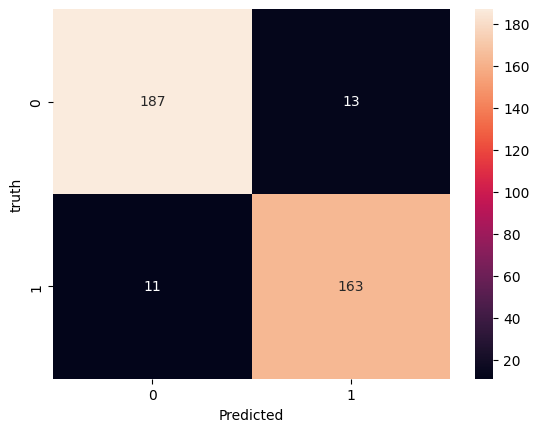

In [17]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('truth')

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.93      0.94      0.93       174

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374

